In [1]:
import sys

sys.path.append('../GraphStructureLearning')

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import pickle

from torch_geometric.data import Data as gData
from torch_geometric.utils import to_networkx, to_undirected
from torch_geometric.nn import MessagePassing

import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric_temporal.nn.recurrent import DCRNN

In [3]:
from torch_geometric.utils import to_undirected, to_dense_adj, add_self_loops, sort_edge_index, remove_self_loops

# GTS

In [4]:
from models.GTS.gts_graph_learning import GTS_Graph_Learning
from models.GTS.gts_forecasting_module import GTS_Forecasting_Module
from models.GTS.DCRNN import DCRNN
from utils.utils import build_fully_connected_edge_idx, build_batch_edge_index

from glob import glob
import yaml
from easydict import EasyDict as edict

In [5]:
config_file = glob('./config/GTS/*.yaml')[0]
config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))

In [6]:
config

{'exp_name': 1,
 'exp_dir': './exp',
 'use_gpu': False,
 'device': 'cpu',
 'seed': 1010,
 'model_name': 'GTS',
 'graph_learning_module': 'GTS',
 'graph_forecasting_module': 'GTS',
 'initial_edge_index': 'Fully Connected',
 'dataset': {'root': './data/spike_lambda_bin100',
  'name': 'spike_lambda_bin100',
  'graph_learning_length': 4800,
  'idx_ratio': 0.5,
  'window_size': 20,
  'slide': 5,
  'pred_step': 5,
  'train_valid_test': [4000, 4400, 4800],
  'save': './data/spike_lambda_bin100/'},
 'train': {'optimizer': 'Adam',
  'epoch': 2,
  'loss_function': 'MSELoss',
  'lr': 0.001,
  'momentum': 0.9,
  'wd': 0.0,
  'batch_size': 1,
  'lr_decay': 0.1,
  'lr_decay_steps': [10000]},
 'nodes_num': 100,
 'node_features': 1,
 'hidden_dim': 16,
 'embedding_dim': 16,
 'graph_learning': {'sequence': 3,
  'mode': 'both',
  'to_symmetric': True,
  'correlation_act_fnc': 'sigmoid',
  'kernel_size': [200, 80, 10],
  'stride': [20, 10, 5],
  'conv1_dim': 4,
  'conv2_dim': 4,
  'conv3_dim': 4},
 'forec

In [7]:
# node_feas = torch.rand(config.nodes_num, config.node_features, 1000)
# edge_index = build_fully_connected_edge_idx(num_nodes=config.nodes_num)

In [8]:
spike = pickle.load(open('./data/spk_bin_n100.pickle', 'rb'))

spike = torch.FloatTensor(spike[:,:4800])

In [9]:
config.nodes_num = 100

In [10]:
edge_index = build_fully_connected_edge_idx(num_nodes=config.nodes_num)

In [11]:
def adj_sampling(adj, edge_index):
    z_1 = F.gumbel_softmax(adj, hard=True)
    z_adj = torch.where(z_1[:,0])

    b= edge_index[0,:][z_adj]
    c = edge_index[1,:][z_adj]

    a = torch.stack([b,c])
    return a

In [12]:
gl = GTS_Graph_Learning(config, 2)
wl = GTS_Graph_Learning(config, 1)

In [13]:
epoch = 3

In [14]:
def weight_sampling(weight, edge_index):
    mat = to_dense_adj(edge_index)

torch.Size([9900, 2])
torch.Size([4569, 2])
torch.Size([2154, 2])
torch.Size([996, 2])


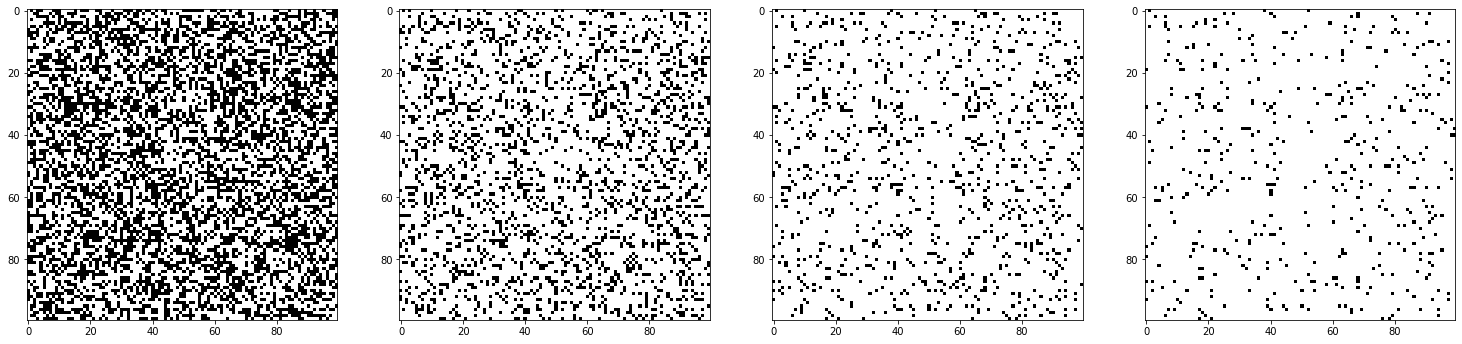

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=epoch+1, figsize=(25.6, 18.0))

adj = gl(spike, edge_index)
print(adj.shape)
_weight = wl(spike, edge_index)

_edge_index = adj_sampling(adj, edge_index)
temp = to_dense_adj(_edge_index)[0]
axes[0].imshow(temp, cmap='Greys')

for ii in range(epoch):
    adj = gl(spike, _edge_index)
    print(adj.shape)
    _edge_index = adj_sampling(adj, _edge_index)
    
    temp = to_dense_adj(_edge_index)[0]
    axes[ii+1].imshow(temp, cmap='Greys')

In [16]:
adj = gl(spike, edge_index)
_edge_index = adj_sampling(adj, edge_index)
temp = to_dense_adj(_edge_index)[0]

for ii in range(epoch):
    adj = gl(spike, _edge_index)
    _edge_index = adj_sampling(adj, _edge_index)
    temp = to_dense_adj(_edge_index)[0]

_mat = to_dense_adj(_edge_index)[0]
_weight = wl(spike, _edge_index)
_weight_mat = to_dense_adj(_edge_index, edge_attr=_weight).squeeze()

In [17]:
_mat

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [18]:
_edge_index

tensor([[ 0,  0,  0,  ..., 99, 99, 99],
        [23, 31, 54,  ..., 29, 38, 79]])

In [21]:
_weight_mat.shape

torch.Size([100, 100])

In [23]:
sigmoid = nn.Sigmoid()

In [24]:
sigmoid(_mat)

tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.7311],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.7311],
        ...,
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]])

In [ ]:
_weight.T

In [ ]:
tt = (_weight_mat + _weight_mat.T)*0.5

In [ ]:
_edge_index.shape

In [ ]:
temp = []

for ii in range(_edge_index.shape[1]):
    row, col = _edge_index[0, ii], _edge_index[1, ii]
    temp.append(tt[row,col])

In [ ]:
temp

In [ ]:
_weight.shape

In [ ]:
output = torch.stack(temp).view(-1, 1)

In [ ]:
output.shape

In [ ]:
temp = []

for row in range(0,100):
    for col in range(0,100):
        if _mat[row,col] == 1:
            